In [0]:
from google.colab import files
uploaded = files.upload()

Saving TBBTs1repr.txt to TBBTs1repr.txt


In [0]:
import codecs
import pandas as pd
with codecs.open('TBBTs1repr.txt', 'r', encoding='utf-8', 
                 errors='ignore') as f:
                 data = pd.read_csv(f, delimiter=':', header = None)
data.head()

,0,1
0,Sheldon,So if a photon is directed through a plane wi...
1,Leonard,"Agreed, what's your point?"
2,Sheldon,"There's no point, I just think it's a good id..."
3,Leonard,"One across is Aegean, eight down is Nabakov, ..."
4,Leonard,"Yes. Um, is this the High IQ sperm bank?"


In [0]:
data.to_csv('tbt1season')

In [0]:
data_tbt = pd.DataFrame()
data_tbt['label'] = data[0]
data_tbt['text'] = data[1]
data_tbt.head()

,label,text
0,Sheldon,So if a photon is directed through a plane wi...
1,Leonard,"Agreed, what's your point?"
2,Sheldon,"There's no point, I just think it's a good id..."
3,Leonard,"One across is Aegean, eight down is Nabakov, ..."
4,Leonard,"Yes. Um, is this the High IQ sperm bank?"


In [0]:
data_tbt.describe

<bound method NDFrame.describe of         label  ... verb_number
0     Sheldon  ...           6
1     Leonard  ...           1
2     Sheldon  ...           1
3     Leonard  ...           2
4     Leonard  ...           0
...       ...  ...         ...
2518    Penny  ...           1
2519    Penny  ...           1
2520  Sheldon  ...           0
2521  Sheldon  ...           0
2522  Sheldon  ...           0

[2523 rows x 4 columns]>

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
import re
import spacy

In [0]:
nlp = spacy.load('en',disable=['parser', 'ner', 'textcat'])

def reduce_to_double_max(text):
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    return re.sub(r'(\W)\1+', r'\1', text)
def preprocess_corpus(corpus):
    data_pro = []
    data_ = []
    corpus = (reduce_to_double_max(s.lower()) for s in corpus)
    docs = nlp.pipe(corpus, batch_size=1000, n_threads=4)
    return [[x.lemma_ for x in doc if x.is_alpha and not x.is_stop] for doc in docs]

In [0]:
data_pro = preprocess_corpus(data_tbt['text'])
data_tbt['text'] = data_pro

In [0]:
token_len = []
for i in data_tbt['text']:
    token_len.append(len(i))
data_tbt['token_number'] = token_len

In [0]:
whole_verb = []
for i in data_tbt['text']:
    verbs = []
    doc = nlp(' '.join(i))
    for s in doc:
        verbs.append(s.pos_)
    whole_verb.append(verbs)
verb_count = []
for i, x in enumerate(whole_verb):
    verb_count.insert(i, x.count('VERB'))
data_tbt['verb_number'] = verb_count

In [0]:
import numpy as np
vecs = pd.DataFrame(index = data_tbt.index, columns = [d for d in range(96)])
for i, t in enumerate(data_tbt['text']): # для каждой строки в датафрейме
    t_vec = (nlp(' '.join(t))).vector # векторизуем текст
    if t_vec.shape == (0,):
        vecs.values[i] = np.array(0)*96 # заменяем строчки на наш вектор
    else:
        vecs.values[i] = t_vec

In [0]:
data_new = pd.concat([data_tbt.drop(['text'], axis = 1), vecs], axis=1)
data_new.head()

,label,token_number,verb_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,Sheldon,15,6,2.71854,-1.69295,-1.37983,-2.75074,-1.20803,-0.244602,3.96906,-0.777473,-1.83566,0.414197,0.105504,-1.21259,1.19482,-2.44159,-0.432531,0.649202,-0.753645,0.928621,-0.942427,2.19147,-0.920059,-2.06194,2.69526,2.16205,2.81637,1.85688,2.04901,-0.60804,0.770163,5.72771,0.711163,0.746499,-1.0197,1.63738,2.39808,1.02307,-2.1316,...,0.253926,0.166492,-1.06922,0.941752,-1.58647,-1.5046,3.00013,-0.816495,-1.28644,0.517785,2.10685,1.8316,-0.146028,2.34653,1.77045,-1.2526,1.0053,0.621164,1.8708,0.144951,-0.0552356,-0.068831,-0.199255,-1.58289,-1.40903,-1.5122,-1.38704,3.98262,-0.904311,-1.35329,0.658382,-0.862337,4.33871,-0.490098,-0.768481,-0.816859,-0.507383,-1.3906,-3.11994,0.131066
1,Leonard,2,1,6.02366,-1.8192,1.01357,-2.84733,-1.13786,-0.310215,1.90259,-3.13564,-4.29688,-0.895856,-0.595898,-0.927388,-0.0380634,-0.895255,0.0310076,0.352337,-0.63045,1.27658,1.01737,2.13218,-2.28408,-2.71677,3.19517,0.310333,-1.11384,1.02826,1.09783,-1.04047,-1.87171,6.02528,1.72662,-1.7212,0.812062,3.71952,2.03655,2.31319,0.541923,...,1.25028,0.267096,1.25234,1.12003,0.868547,0.388889,1.19685,1.94884,-0.926095,-0.36848,-0.967613,-0.102845,0.251481,3.48753,1.87524,-3.04992,-0.0289081,-1.4669,0.523738,2.5442,-0.101736,0.982604,-2.21325,0.607803,-0.991935,0.318405,-1.04227,2.7439,-0.905751,-2.95808,0.856815,-2.35612,3.92044,-0.0664591,2.61211,-2.60908,3.12441,-0.883338,-1.65415,0.653254
2,Sheldon,6,1,3.67645,-2.12415,1.26999,-2.24487,-2.02412,0.298901,3.55186,-1.13206,-1.40121,1.14289,-0.422661,-0.580119,-0.435215,-2.72085,1.11855,0.276999,0.934364,1.33578,-0.333408,2.68171,-0.755454,-1.96291,1.12305,2.57518,1.18074,1.54403,1.81452,-1.29589,-0.221793,6.66188,-1.18066,-0.547833,-0.709512,1.10137,2.00723,1.58817,-0.339205,...,1.29968,0.0268929,-0.930526,0.727847,-1.19275,-0.490711,2.82957,-1.58232,0.383225,1.08168,0.793271,1.85126,-0.666013,2.14725,1.46802,-2.01419,1.26345,0.630267,1.19709,0.660847,-1.4955,1.61964,-1.72201,-1.67134,-2.33495,-0.500434,-1.15182,3.46047,-0.239297,-1.66999,0.161884,-0.681843,3.96972,-0.548487,0.290827,-0.275648,-0.754272,-1.8701,-1.73342,1.09986
3,Leonard,19,2,1.78056,-2.64,-1.31757,-1.81627,-1.57533,1.0343,3.87847,0.832834,-1.80127,1.47268,-0.619456,-0.731292,0.331141,-1.63907,-0.370965,-1.39959,1.11918,1.36117,0.0493754,2.30287,-0.620399,-2.15794,1.82345,2.53002,1.76269,1.54639,1.23007,-2.36225,1.74923,3.7952,-0.465761,0.0368299,-0.845251,0.538286,2.47414,1.27791,-1.67623,...,1.06309,0.713684,-0.689146,0.844137,-2.35981,-1.11697,2.34019,-1.02254,-0.720008,2.4287,-0.947547,-0.331976,-0.55439,1.05925,1.50308,-1.04619,0.612561,1.73307,2.31899,1.06315,-0.955065,-0.421596,-1.82926,-2.23067,-1.241,-1.72531,-1.2927,3.55299,0.434448,-0.652515,0.0101902,-0.361861,3.6175,-0.69205,-1.14206,1.0422,-0.50199,-0.956701,-1.33986,0.707906
4,Leonard,6,0,1.21365,-2.07647,0.766395,-1.69032,-0.507166,-0.8967,1.49741,-1.46111,-1.3988,1.83502,0.385584,-0.437192,-1.33439,-4.06351,-2.17151,0.9561,0.0182525,1.17869,1.25195,1.55627,1.17939,-1.25698,0.927937,1.59864,-0.0642736,1.63696,0.0797467,0.869216,-0.130546,6.24029,-2.12251,-0.881989,-1.20348,2.82055,-0.503472,2.19665,3.26497,...,1.77402,0.51058,-3.21021,0.14417,0.104315,0.552795,1.39872,2.04901,0.454828,2.34558,4.35897,-0.63109,0.639288,1.55446,2.04968,-1.7149,-0.573185,-1.65724,-0.569967,-1.40546,-0.812901,2.77598,0.410078,-1.49951,-2.46254,0.984798,-1.42005,0.94342,0.0749236,-1.30051,1.24954,0.190347,2.48614,-1.18694,-0.151259,0.54332,-1.86474,-0.257653,0.122237,2.23082


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_new.drop(['label'], axis = 1), data_new['label'], test_size=0.33, random_state=42)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
train_class = encoder.transform(y_train)
test_class = encoder.transform(y_test)
dict(enumerate(encoder.classes_))

{0: 'Howard', 1: 'Leonard', 2: 'Penny', 3: 'Raj', 4: 'Sheldon'}

In [0]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, train_class)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(test_class, y_pred))
print("Precision:",metrics.precision_score(test_class, y_pred, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred, average='macro'))

Accuracy: 0.382953181272509
Precision: 0.24634989029801116
Recall: 0.2510695254334808


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, train_class)
y_pred_log=logreg.predict(x_test)
cnf_matrix = metrics.confusion_matrix(test_class, y_pred_log)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[  3,  42,   9,   2,  50],
       [ 10,  82,  21,   5, 100],
       [  3,  47,  29,   3,  57],
       [  4,  16,   4,   3,  24],
       [ 12,  73,  22,  11, 201]])

In [0]:
print("Accuracy:",metrics.accuracy_score(test_class, y_pred_log))
print("Precision:",metrics.precision_score(test_class, y_pred_log, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_log, average='macro'))

Accuracy: 0.3817527010804322
Precision: 0.2681177727501257
Recall: 0.26039986852147406


Text(0.5, 257.44, 'Predicted label')

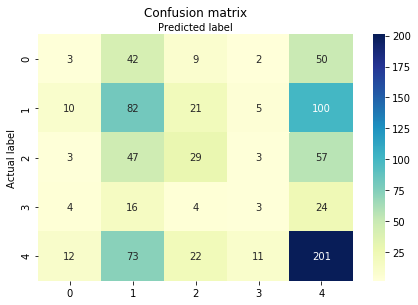

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names= list(dict(enumerate(encoder.classes_)).values()) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(dict(enumerate(encoder.classes_))))
plt.xticks(tick_marks, list(dict(enumerate(encoder.classes_)).values()))
plt.yticks(tick_marks, list(dict(enumerate(encoder.classes_)).values()))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
from sklearn.ensemble import RandomForestClassifier


rdf=RandomForestClassifier(n_estimators=50)
rdf.fit(x_train, train_class)
y_pred_rnf=rdf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(test_class, y_pred_rnf))
print("Precision:",metrics.precision_score(test_class, y_pred_rnf, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_rnf, average='macro'))

Accuracy: 0.3949579831932773
Precision: 0.28114493310685534
Recall: 0.2604574707784697


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
data_string = []
for i in data_tbt['text']:
  data_string.append(' '.join(i))
data_tbt_string = pd.DataFrame()
data_tbt_string['label'] = data_tbt['label']
data_tbt_string['text'] = data_string
data_tbt_string['token_number'] = data_tbt['token_number']
data_tbt_string['verb_number'] = data_tbt['verb_number']
data_tbt_string.head()

,label,text,token_number,verb_number
0,Sheldon,photon direct plane slit slit observe slit uno...,15,6
1,Leonard,agree point,2,1
2,Sheldon,point think good idea tee shirt,6,1
3,Leonard,aegean nabakov mcm fourteen finger phylum make...,19,2
4,Leonard,yes um high iq sperm bank,6,0


In [0]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(data_tbt_string.drop(['label'], axis = 1), data_tbt_string['label'], test_size=0.33, random_state=42)

In [0]:
encoder.fit(y_train_1)
train_class_1 = encoder.transform(y_train_1)
test_class_1 = encoder.transform(y_test_1)
dict(enumerate(encoder.classes_))

{0: 'Howard', 1: 'Leonard', 2: 'Penny', 3: 'Raj', 4: 'Sheldon'}

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_1 = TfidfVectorizer(max_df=0.87,
               smooth_idf=1, max_features=300000)
#tf-idf
train_tf =  vect_1.fit_transform(x_train_1['text'])
test_tf = vect_1.transform(x_test_1['text'])

In [0]:
logreg = LogisticRegression()
logreg.fit(train_tf, train_class_1)
y_pred_log_1=logreg.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_log_1))
print("Precision:",metrics.precision_score(test_class_1, y_pred_log_1, average='macro'))
print("Recall:",metrics.recall_score(test_class_1, y_pred_log_1, average='macro'))
print("F1-score:",metrics.f1_score(test_class_1, y_pred_log_1, average='macro'))

Accuracy: 0.4309723889555822
Precision: 0.5627296734065469
Recall: 0.2960374551544504
F1-score: 0.28720225127378723


In [0]:
clf_1 = svm.SVC(kernel='linear') # Linear Kernel
clf_1.fit(train_tf, train_class_1)
y_pred_1 = clf_1.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_1))
print("Precision:",metrics.precision_score(test_class_1, y_pred_1, average='macro'))
print("Recall:",metrics.recall_score(test_class_1, y_pred_1, average='macro'))

Accuracy: 0.41656662665066024
Precision: 0.4172952602952603
Recall: 0.3017767983039052


In [0]:
rdf_1 = RandomForestClassifier(n_estimators=50)
rdf_1.fit(train_tf, train_class_1)
y_pred_rnf_1 = rdf_1.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_rnf_1))
print("Precision:",metrics.precision_score(test_class, y_pred_rnf_1, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_rnf_1, average='macro'))

Accuracy: 0.3697478991596639
Precision: 0.33096472072516253
Recall: 0.2940960543617188


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import warnings

warnings.filterwarnings('ignore', category = DeprecationWarning)

In [0]:
text_data = data_pro
id2word = corpora.Dictionary(text_data)
texts = text_data
corpus = [id2word.doc2bow(text) for text in texts]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=id2word, passes=15)
topics = lda_model.print_topics(num_words=6)
for t in topics:
    print(t)

(0, '0.024*"know" + 0.022*"okay" + 0.019*"go" + 0.010*"sheldon" + 0.010*"want" + 0.009*"leonard"')
(1, '0.016*"penny" + 0.013*"like" + 0.012*"oh" + 0.010*"right" + 0.010*"go" + 0.008*"sister"')
(2, '0.016*"oh" + 0.014*"okay" + 0.014*"look" + 0.013*"know" + 0.012*"yeah" + 0.012*"leonard"')
(3, '0.026*"time" + 0.018*"machine" + 0.014*"want" + 0.013*"get" + 0.012*"think" + 0.011*"oh"')
(4, '0.008*"think" + 0.008*"way" + 0.008*"yes" + 0.007*"oh" + 0.007*"alright" + 0.007*"go"')


In [0]:
pyLDAvis.enable_notebook()
showme = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
showme

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.109535 -0.165111       1        1  30.509991
0      0.090485  0.049755       2        1  20.449512
3      0.029969  0.082379       3        1  17.011463
1     -0.192485 -0.079695       4        1  16.373522
2     -0.037503  0.112671       5        1  15.655512, topic_info=     Category        Freq   Term       Total  loglift  logprob
92    Default   98.000000   want   98.000000  30.0000  30.0000
234   Default   78.000000   come   78.000000  29.0000  29.0000
128   Default  160.000000     oh  160.000000  28.0000  28.0000
219   Default   67.000000   yeah   67.000000  27.0000  27.0000
16    Default   94.000000  think   94.000000  26.0000  26.0000
...       ...         ...    ...         ...      ...      ...
12     Topic5    9.051333   good   55.395168   0.0428  -5.5509
204    Topic5    9.601562   like   88.959244  -0.3719  -5.4919
1392   Topic5    7.989011  throw   24.448090   0.7359  -5.6758
70     Topic5    8.224612   know  162.676086  -1.1303  -5.6467
128    Topic5    7.596157     oh  160.656693  -1.1973  -5.7262

[323 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1190      1  0.898178   addition
1790      1  0.881427      ahead
928       1  0.759719    alright
928       2  0.084413    alright
928       4  0.168827    alright
...     ...       ...        ...
332       5  0.246944       year
1664      3  0.901047       yell
3468      4  0.781914  yesterday
4009      2  0.932404        yip
3512      2  0.932409         zz

[428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

In [0]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

Perplexity:  -8.193285532872613


In [0]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3879567153864695


In [0]:
data_tbt.head()

,label,text,token_number,verb_number
0,Sheldon,"[photon, direct, plane, slit, slit, observe, s...",15,6
1,Leonard,"[agree, point]",2,1
2,Sheldon,"[point, think, good, idea, tee, shirt]",6,1
3,Leonard,"[aegean, nabakov, mcm, fourteen, finger, phylu...",19,2
4,Leonard,"[yes, um, high, iq, sperm, bank]",6,0


In [0]:
dict_lda = {}
for i in dict(enumerate(encoder.classes_)).values():
  dict_lda[i] = []
dict_lda

{'Howard': [], 'Leonard': [], 'Penny': [], 'Raj': [], 'Sheldon': []}

In [0]:
for x, y in enumerate(data_tbt['text']):
  dict_lda[data_tbt['label'][x]].append(y)

In [0]:
dict_viz = {}
for i in dict_lda:
  text_data = dict_lda[i]
  id2word = corpora.Dictionary(text_data)
  texts = text_data
  corpus = [id2word.doc2bow(text) for text in texts]
  lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=id2word, passes=15)
  dict_viz[i] = [lda_model, corpus, id2word]
  topics = lda_model.print_topics(num_words=5)
  print('Topics of', i)
  for t in topics:
    print(t)

Topics of Howard
(0, '0.013*"know" + 0.011*"get" + 0.009*"sheldon" + 0.009*"like" + 0.008*"look"')
(1, '0.012*"think" + 0.012*"sheldon" + 0.011*"get" + 0.008*"need" + 0.008*"girl"')
(2, '0.010*"lady" + 0.009*"right" + 0.007*"good" + 0.007*"speak" + 0.006*"talk"')
Topics of Leonard
(0, '0.018*"go" + 0.017*"come" + 0.009*"sheldon" + 0.009*"need" + 0.008*"know"')
(1, '0.016*"know" + 0.015*"okay" + 0.012*"oh" + 0.009*"thing" + 0.009*"sheldon"')
(2, '0.019*"penny" + 0.015*"like" + 0.014*"sheldon" + 0.011*"oh" + 0.011*"uh"')
Topics of Penny
(0, '0.023*"okay" + 0.022*"yeah" + 0.021*"know" + 0.019*"want" + 0.017*"get"')
(1, '0.042*"oh" + 0.027*"guy" + 0.020*"go" + 0.017*"leonard" + 0.017*"good"')
(2, '0.034*"okay" + 0.021*"know" + 0.018*"think" + 0.018*"need" + 0.013*"hey"')
Topics of Raj
(0, '0.015*"little" + 0.013*"lalita" + 0.011*"girl" + 0.010*"dude" + 0.010*"maybe"')
(1, '0.022*"oh" + 0.015*"time" + 0.014*"get" + 0.014*"hee" + 0.012*"indian"')
(2, '0.012*"oh" + 0.008*"new" + 0.008*"sheldo

In [0]:
pyLDAvis.enable_notebook()
showme = pyLDAvis.gensim.prepare(dict_viz['Howard'][0], dict_viz['Howard'][1], dict_viz['Howard'][2])
showme

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.044066 -0.175949       1        1  39.705456
1     -0.137424  0.124442       2        1  30.319315
2      0.181491  0.051507       3        1  29.975224, topic_info=    Category       Freq   Term      Total  loglift  logprob
109  Default  56.000000    get  56.000000  30.0000  30.0000
17   Default  20.000000   want  20.000000  29.0000  29.0000
394  Default  18.000000   chka  18.000000  28.0000  28.0000
337  Default  33.000000   time  33.000000  27.0000  27.0000
242  Default  35.000000  think  35.000000  26.0000  26.0000
..       ...        ...    ...        ...      ...      ...
133   Topic3  10.308393     go  38.896374  -0.1231  -5.0702
93    Topic3  10.461403   like  43.653873  -0.2238  -5.0555
82    Topic3   7.872170   turn  20.890833   0.2288  -5.3398
10    Topic3   7.793444  right  33.608612  -0.2567  -5.3499
391   Topic3   7.428994   need  33.990307  -0.3159  -5.3978

[199 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
167       2  0.859111    alright
597       1  0.837736        art
18        2  0.859108  available
816       1  0.837729       away
84        1  0.223906       baby
...     ...       ...        ...
12        1  0.424688       yeah
12        2  0.552095       yeah
439       1  0.854784       year
439       2  0.160272       year
718       3  0.856634      young

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [0]:
from google.colab import files
uploaded = files.upload()

Saving tbt1season_1.txt to tbt1season_1.txt


In [0]:
import codecs
import pandas as pd
with codecs.open('tbt1season_1.txt', 'r', encoding='utf-8', 
                 errors='ignore') as f:
                 data_ep = pd.read_csv(f, delimiter='\t', header = None)
data_ep.head()

,0,1,2,3
0,0,Sheldon,So if a photon is directed through a plane wi...,1
1,1,Leonard,"Agreed, what's your point?",1
2,2,Sheldon,"There's no point, I just think it's a good id...",1
3,3,Leonard,"One across is Aegean, eight down is Nabakov, ...",1
4,4,Leonard,"Yes. Um, is this the High IQ sperm bank?",1


In [0]:
data_ep = data_ep.drop([0], axis = 1)

In [0]:
data_ep.rename(columns={1: 'label', 2: 'text', 3: 'episode'}, inplace=True)

In [0]:
data_ep.head()

,label,text,episode
0,Sheldon,So if a photon is directed through a plane wi...,1
1,Leonard,"Agreed, what's your point?",1
2,Sheldon,"There's no point, I just think it's a good id...",1
3,Leonard,"One across is Aegean, eight down is Nabakov, ...",1
4,Leonard,"Yes. Um, is this the High IQ sperm bank?",1


In [0]:
data_pro_ep = preprocess_corpus(data_ep['text'])
data_ep['text'] = data_pro_ep
token_len_ep = []
for i in data_ep['text']:
    token_len_ep.append(len(i))
data_ep['token_number'] = token_len_ep
data_ep.head()

,label,text,episode,token_number
0,Sheldon,"[photon, direct, plane, slit, slit, observe, s...",1,15
1,Leonard,"[agree, point]",1,2
2,Sheldon,"[point, think, good, idea, tee, shirt]",1,6
3,Leonard,"[aegean, nabakov, mcm, fourteen, finger, phylu...",1,19
4,Leonard,"[yes, um, high, iq, sperm, bank]",1,6


In [0]:
dict_ep = {}
for i in dict(enumerate(encoder.classes_)).values():
  dict_ep[i] = [0]*data_ep['episode'].nunique()

In [0]:
for x, y in enumerate(data_ep['token_number']):
  dict_ep[data_ep['label'][x]][data_ep['episode'][x]-1] += y

In [0]:
words_ = 0
for i in data_ep['token_number']:
  words_ += i
words_

14886

In [0]:
dict_ep

{'Howard': [96,
  266,
  489,
  468,
  333,
  257,
  475,
  533,
  554,
  427,
  466,
  487,
  788,
  757,
  665,
  706,
  677],
 'Leonard': [368,
  1070,
  1935,
  1699,
  1501,
  971,
  1111,
  1061,
  988,
  999,
  1293,
  958,
  1009,
  1119,
  1141,
  946,
  769],
 'Penny': [182,
  594,
  828,
  620,
  414,
  453,
  655,
  697,
  798,
  709,
  733,
  623,
  465,
  425,
  585,
  578,
  911],
 'Raj': [3,
  60,
  147,
  181,
  100,
  157,
  208,
  487,
  571,
  559,
  120,
  157,
  273,
  433,
  551,
  525,
  307],
 'Sheldon': [419,
  1182,
  1819,
  1753,
  1651,
  1719,
  1456,
  1485,
  1523,
  1570,
  1637,
  1894,
  1607,
  1697,
  1568,
  1672,
  1681]}

In [0]:
ddd = []
for i in dict_lda['Howard']:
  ddd.append(' '.join(i))
' '.join(ddd)

'wait till stephen hawk lecture mit creepy computer voice yeah right grandmother town hang lady want anticipate coitus available coitus enchante madamoiselle howard wolowitz cal tech department applied physics familiar work currently orbit jupiter large moon take high resolution digital photograph bon douche french good shower sentiment express language ka tong guay jow oh speak english speak woman kind nerd juice box favourite place kick quest great house ale yeah level button game character hang maybe quest turn leave lake street head colorado know wonderful little sushi bar karaoke baby baby hooked uh baby baby hooked peanut oil look puffy feel puffy look finger like vienna sausage tell beautiful flawless russian talk attractive woman case cheesecake scent goddess yeah problem fly night grab napkin homie get serve rajesh koothrapali speak penny hug hug perfume smell oh boy afraid instruction pictographic representation imaginative way assemble component right sweden space program go

In [0]:
heroes = {}
for i in dict_lda:
  record = []
  for s in dict_lda[i]:
    record.append(' '.join(s))
  heroes[i] = ' '.join(record)
heroes

{'Howard': 'wait till stephen hawk lecture mit creepy computer voice yeah right grandmother town hang lady want anticipate coitus available coitus enchante madamoiselle howard wolowitz cal tech department applied physics familiar work currently orbit jupiter large moon take high resolution digital photograph bon douche french good shower sentiment express language ka tong guay jow oh speak english speak woman kind nerd juice box favourite place kick quest great house ale yeah level button game character hang maybe quest turn leave lake street head colorado know wonderful little sushi bar karaoke baby baby hooked uh baby baby hooked peanut oil look puffy feel puffy look finger like vienna sausage tell beautiful flawless russian talk attractive woman case cheesecake scent goddess yeah problem fly night grab napkin homie get serve rajesh koothrapali speak penny hug hug perfume smell oh boy afraid instruction pictographic representation imaginative way assemble component right sweden space

In [0]:
from collections import Counter
import re

In [0]:
for key, value in heroes.items():
  cnt = Counter(x for x in re.findall(r'[a-z\']{2,}', value))
  print(key, cnt.most_common(10))

Howard [('sheldon', 69), ('get', 66), ('like', 51), ('know', 48), ('look', 48), ('oh', 45), ('go', 45), ('think', 42), ('right', 39), ('time', 39)]
Leonard [('know', 177), ('sheldon', 174), ('go', 174), ('penny', 165), ('oh', 162), ('okay', 153), ('like', 132), ('think', 102), ('come', 99), ('get', 99)]
Penny [('okay', 213), ('oh', 198), ('know', 159), ('guy', 129), ('leonard', 126), ('get', 102), ('sheldon', 96), ('go', 93), ('yeah', 90), ('want', 84)]
Raj [('oh', 60), ('get', 36), ('little', 36), ('look', 30), ('time', 30), ('know', 30), ('like', 27), ('girl', 24), ('tell', 24), ('parent', 21)]
Sheldon [('go', 174), ('think', 174), ('know', 156), ('leonard', 153), ('oh', 150), ('time', 138), ('want', 126), ('penny', 126), ('need', 120), ('yes', 96)]
